In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [2]:
import os
import scipy.ndimage
import multiprocessing
from multiprocessing import Pool
import struct
import random
import math

In [3]:
import numpy as np
import pandas as pd
import seaborn as sns
from scipy import stats
from scipy import optimize as opt
import scipy
from scipy.io import loadmat  
import matplotlib as mpl
import matplotlib.pyplot as plt

In [4]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL']='2'
import tensorflow as tf

In [5]:
# Forked from 'https://gist.github.com/akesling/5358964' -> GPL2
def read(path):
    """
    Python function for importing the MNIST data set.  It returns an iterator
    of 2-tuples with the first element being the label and the second element
    being a numpy.uint8 2D array of pixel data for the given image. 
    """

    fname_img = os.path.join(path, 'training_set_images')
    fname_lbl = os.path.join(path, 'training_set_labels')

    # Load everything in some numpy arrays
    with open(fname_lbl, 'rb') as flbl:
        magic, num = struct.unpack(">II", flbl.read(8))
        lbl = np.fromfile(flbl, dtype=np.int8)

    with open(fname_img, 'rb') as fimg:
        magic, num, rows, cols = struct.unpack(">IIII", fimg.read(16))
        img = np.fromfile(fimg, dtype=np.uint8).reshape(len(lbl), rows, cols)

    get_img = lambda idx: (lbl[idx], img[idx])

    # Create an iterator which returns each image in turn
    for i in range(len(lbl)):
        yield get_img(i)

allData = []
for i in read('data/'):
    allData +=  [ (i[1], i[0])]

In [6]:
sampleCount = 10000
data = pd.DataFrame( allData[0:sampleCount], columns=['Image','Label'] )
data.head()

,Image,Label
0,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",5
1,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",0
2,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",4
3,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1
4,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",9


In [7]:
(width, height) = data[0:1]['Image'][0].shape

In [8]:
temp = pd.DataFrame()
for i in range(sampleCount): 
    curr = data['Image'][i]
    (width, height) = curr.shape
    temp = temp.append( pd.DataFrame(curr.reshape((1, width*height))) )

# temp.insert(0, 'Ones', 1)
temp.head()

# sample = allData[ 7 ][0]
# sample = scipy.ndimage.zoom(sample, zoom=zoom)
# plt.imshow(sample)

,0,1,2,3,4,5,6,7,8,9,...,774,775,776,777,778,779,780,781,782,783
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [9]:
dataX = temp
dataY = data['Label']

In [10]:
currIndex = 0
def getBatchData(count):
    global currIndex
    data = np.array( allData[currIndex : currIndex+count] )
    currIndex += count
    
    # X
    x = np.array([])
    for i in data[:,0]:
        x = np.append(x, i)
    x = x.reshape( (len(data), 784) )

    # Y
    y = np.zeros( (len(data), 10) )
    for i in range( len(data) ):
        y[i][data[:,1][i]] = 1

    return (x, y)

# Create the model

In [11]:
x = tf.placeholder(tf.float32, [None, 784])
W = tf.Variable(tf.zeros([784, 10]))
b = tf.Variable(tf.zeros([10]))
y = tf.matmul(x, W) + b

In [12]:
y_ = tf.placeholder(tf.float32, [None, 10])

In [13]:
cross_entropy = tf.reduce_mean( tf.nn.softmax_cross_entropy_with_logits(labels=y_, logits=y))
train_step = tf.train.GradientDescentOptimizer(0.5).minimize(cross_entropy)

In [14]:
sess = tf.InteractiveSession()
tf.global_variables_initializer().run()

In [15]:
currIndex = 0
for _ in range(100):
    batch_xs, batch_ys = getBatchData(100)
    sess.run(train_step, feed_dict={x: batch_xs, y_: batch_ys})

## Test

[[ 0.  0.  0.  1.  0.  0.  0.  0.  0.  0.]]


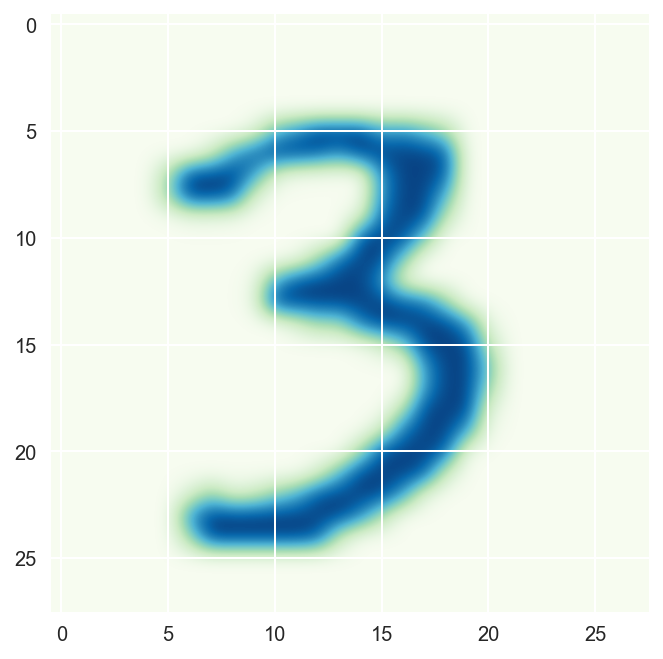

In [16]:
sampleX, sampleY = getBatchData(1)
print( sess.run(tf.nn.softmax(y), {x:sampleX}) )
plt.imshow(sampleX.reshape( (28,28) ), cmap=mpl.cm.GnBu, interpolation="bicubic")

## Accuracy

In [17]:
testSize = 1000

sampleX, sampleY = getBatchData(testSize)
res = sess.run(tf.nn.softmax(y), {x:sampleX})

tt = 0
for i in range(testSize):
    tt += np.array_equal(sampleY[i], res[i])
tt * 100 / testSize

80.5